<a href="https://colab.research.google.com/github/skreddypalvai/Voice_cloning_and_fake_audio_detection/blob/main/Voice_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voice Cloning and Fake Audio Detection**


### **Objective:**
Primary goal is to build algorithms that can synthesize spoken audio by coverting a speaker's voice to another speaker's voice with the end goal to detect if any spoken audio is pristine or fake.

In [ ]:
#Importing necessary libraries
import os
import librosa
import numpy as np
import librosa.display
import wave
from fuzzywuzzy import fuzz
import soundfile as sf
from scipy.io import wavfile
import seaborn as sns
import random
import shutil
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, lfilter
from IPython.display import clear_output, Audio
import wavio
import spacy
import noisereduce as nr
import speech_recognition as sr
from moviepy.editor import concatenate_audioclips, AudioFileClip
import jiwer
from jiwer import wer
import matplotlib.pyplot as plt
import pickle
import re
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#audio file paths
source_train_path = '/content/drive/MyDrive/Colab Notebooks/DR-2'
destination_path = "/content/drive/MyDrive/Colab Notebooks/3fake"

In [ ]:
#Cloning the corresponding GitHub repository to utilize pretrained models for audio file synthesis.
!git clone https://github.com/CorentinJ/Real-Time-Voice-Cloning

Cloning into 'Real-Time-Voice-Cloning'...
remote: Enumerating objects: 2671, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2671 (delta 0), reused 1 (delta 0), pack-reused 2668
Receiving objects: 100% (2671/2671), 361.01 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (1435/1435), done.


In [ ]:
from encoder import inference as encoder
from encoder.params_model import model_embedding_size as speaker_embedding_size
from synthesizer.inference import Synthesizer
from utils.argutils import print_args
from utils.default_models import ensure_default_models
from vocoder import inference as vocoder
from pathlib import Path
from synthesizer.hparams import hparams
from synthesizer.train import train

In [ ]:
encoder_weights = Path("/content/drive/MyDrive/Colab Notebooks/encoder.pt")
synthesizer_weights = Path("/content/drive/MyDrive/Colab Notebooks/synthesizer.pt")
vocoder_weights = Path("/content/drive/MyDrive/Colab Notebooks/vocoder.pt")

In [ ]:
encoder.load_model(encoder_weights)

Loaded encoder "encoder.pt" trained to step 1564501


In [ ]:
synthesizer = Synthesizer(synthesizer_weights)

Synthesizer using device: cuda


In [ ]:
vocoder.load_model(vocoder_weights)

Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at /content/drive/MyDrive/Colab Notebooks/vocoder.pt


In [ ]:
#loading the audio files from the source directory
def load_data_and_extract(base_directory, max_files=300):
    audio_files = []
    text_files = []
    text_contents = []
    file_count = 0
    for speaker_dir in os.listdir(base_directory):
        if file_count >= max_files:
            break
        speaker_path = os.path.join(base_directory, speaker_dir)
        if os.path.isdir(speaker_path):
            for file in os.listdir(speaker_path):
                if file_count >= max_files:
                    break
                base_name, extension = os.path.splitext(os.path.splitext(file)[0])
                if file.lower().endswith(".wav.wav"):
                    audio_path = os.path.join(speaker_path, file)
                    audio_files.append(audio_path)
                    text_path = os.path.join(speaker_path, base_name + '.TXT')
                    text_files.append(text_path)
                    text_content = read_file(text_path)
                    if text_content:
                        text_contents.append(text_content)
                    file_count += 1
    return audio_files,text_files, text_contents
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return None

In [ ]:
source_audio_files, source_text_files, source_train_text= load_data_and_extract(source_train_path)

In [ ]:
sample = source_audio_files[281]
Audio(sample)

In [ ]:
audio_texts = []
for i, text_to_process in enumerate(source_train_text):
    processed_text = re.sub(r'\d+', '', text_to_process)
    audio_texts.append(processed_text)

In [ ]:
audio_texts[281]

'  Geocentricism per se?\n'

In [ ]:
def text_to_voice_batch(audio_file_paths, audio_texts, dest_folder):
    for i, (audio_path, text) in enumerate(zip(audio_file_paths, audio_texts)):
        # Processing each audio file and generating synthesized audio
        in_fpath = audio_path
        preprocessed_wav = encoder.preprocess_wav(in_fpath)
        original_wav, sampling_rate = librosa.load(str(in_fpath))
        preprocessed_wav = encoder.preprocess_wav(original_wav, sampling_rate)
        embed = encoder.embed_utterance(preprocessed_wav)
        texts = [text]
        embeds = [embed]
        specs = synthesizer.synthesize_spectrograms(texts, embeds)
        spec = specs[0]
        generated_wav = vocoder.infer_waveform(spec)
        generated_wav = np.pad(generated_wav, (0, synthesizer.sample_rate), mode="constant")
        # Triming excess silences to compensate for gaps in spectrograms
        generated_wav = encoder.preprocess_wav(generated_wav)
        # Saving the generated audio file in the destination folder
        filename = f"{dest_folder}/fake_audio{i + 1}.wav"
        print(generated_wav.dtype)
        sf.write(filename, generated_wav.astype(np.float32), synthesizer.sample_rate)
        print(f"Saved output as {filename}\n")

In [ ]:
text_to_voice_batch(source_audio_files, audio_texts, destination_path)

Trainable Parameters: 30.870M
Loaded synthesizer "synthesizer.pt" trained to step 295000

| Generating 1/1


Done.

{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 4.1kHz | }float64
Saved output as /content/drive/MyDrive/Colab Notebooks/3fake/fake_audio1.wav


| Generating 1/1


Done.

{| ████████████████ 57000/57600 | Batch Size: 6 | Gen Rate: 6.2kHz | }float64
Saved output as /content/drive/MyDrive/Colab Notebooks/3fake/fake_audio2.wav


| Generating 1/1


Done.

{| ████████████████ 76000/76800 | Batch Size: 8 | Gen Rate: 8.2kHz | }float64
Saved output as /content/drive/MyDrive/Colab Notebooks/3fake/fake_audio3.wav


| Generating 1/1


Done.

{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 4.2kHz | }float64
Saved output as /content/drive/MyDrive/Colab Notebooks/3fake/fake_audio4.wav


| Generating 1/1


Done.

{| ████████████████ 47500/48000 | Batch Size: 5 | Gen Rate: 5.0kHz | }float64
Saved output as /content/drive/MyDrive/Colab Notebooks/3fake/fake_audio5.w

In [ ]:
# now performing speech to text processing using synthesized speech generated from the pretrained models
def speech_to_text(audio):
    r = sr.Recognizer()
    with sr.AudioFile(audio) as src:
        audio = r.record(src)
        text = r.recognize_google(audio, language='en-US')
        return text

In [ ]:
def speech_to_text_batch(audio_folder):
    text_results = []
    # Loop through audio files in the specified folder
    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(audio_folder, audio_file)
            try:
                text = speech_to_text(audio_path)
                text_results.append(text)
            except Exception as e:
                print(f"Error processing {audio_file}")
    return text_results

In [ ]:
generated_audio_folder = "/content/drive/MyDrive/Colab Notebooks/3fake"
fake_texts = speech_to_text_batch(generated_audio_folder)
# Print the results
for  text in fake_texts:
    print(f"Text : {text}")

Error processing fake_audio9.wav
Error processing fake_audio13.wav
Error processing fake_audio40.wav
Error processing fake_audio42.wav
Error processing fake_audio54.wav
Error processing fake_audio65.wav
Error processing fake_audio70.wav
Error processing fake_audio74.wav
Error processing fake_audio75.wav
Error processing fake_audio106.wav
Error processing fake_audio118.wav
Error processing fake_audio134.wav
Error processing fake_audio141.wav
Error processing fake_audio149.wav
Error processing fake_audio162.wav
Error processing fake_audio163.wav
Error processing fake_audio173.wav
Error processing fake_audio177.wav
Error processing fake_audio178.wav
Error processing fake_audio180.wav
Error processing fake_audio181.wav
Error processing fake_audio183.wav
Error processing fake_audio186.wav
Error processing fake_audio187.wav
Error processing fake_audio189.wav
Error processing fake_audio197.wav
Error processing fake_audio202.wav
Error processing fake_audio220.wav
Error processing fake_audio225

In [ ]:
indexes_to_delete = [8,12,39,41,53]
for index in sorted(indexes_to_delete, reverse=True):
    del audio_texts[index]

In [ ]:
# After successfully generating text from the synthesized audio files, we are now comparing the original texts with the generated (cloned) texts
def text_comparison(t, original_text):
    if not t or not original_text:
        print("Error: Input text is empty.")
        return None
    transformation = jiwer.Compose([jiwer.ToLowerCase(),
                                    jiwer.RemoveWhiteSpace(replace_by_space=True),
                                    jiwer.Strip(),
                                    jiwer.ReduceToListOfListOfWords(word_delimiter=" ")])
    try:
        word_error_rate = jiwer.wer(original_text, t, truth_transform=transformation, hypothesis_transform=transformation)
    except Exception as e:
        print(f"Error calculating Word Error Rate: {e}")
        word_error_rate = None
    print('cloned_text: ', t)
    print('original_text: ', original_text)
    print("Word Error Rate:", word_error_rate)
    similarity_score = fuzz.ratio(original_text, t) / 100
    print("Similarity Score:", similarity_score)
    print("__" * 50)
    return word_error_rate, similarity_score

In [ ]:
file_limit = 50
#Using Word Error Rate and Similarity Score to evaluate the differences between the two text files.
for i, (actual_text, fake_text) in enumerate(zip(audio_texts, fake_texts), start=1):
    print(f"Evaluating Pair {i}")
    word_error_rate, similarity_score = text_comparison(fake_text, actual_text)
    print("\n" + "_" * 100)
    if i >= file_limit:
        print(f"Reached the file limit of {file_limit}. Exiting the loop.")
        break

Evaluating Pair 1
cloned_text:  what outfit does
original_text:    What outfit does she drive for?

Word Error Rate: 0.5
Similarity Score: 0.6
____________________________________________________________________________________________________

____________________________________________________________________________________________________
Evaluating Pair 2
cloned_text:  what's the weather for high after Rachel's talk
original_text:    We'll serve rhubarb pie after Rachel's talk.

Word Error Rate: 0.8571428571428571
Similarity Score: 0.62
____________________________________________________________________________________________________

____________________________________________________________________________________________________
Evaluating Pair 3
cloned_text:  assume for example of a situation where a farm has a packing shit and field
original_text:    Assume, for example, a situation where a farm has a packing shed and fields.

Word Error Rate: 0.35714285714285715
Similar

### Fake Audio Detection

In [ ]:
# Defining a function to extract MFCC and Mel features from audio files.
def extract_features(audio_path, mfcc=True, chroma=True, mel=True):
    audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
    features = []
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=1)
        features.extend(mfccs)
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate), axis=1)
        features.extend(chroma)
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate), axis=1)
        features.extend(mel)
    return features

In [ ]:
def load_data(audio_folder, label, max_files=300):
    data = []
    labels = []
    file_count = 0
    for filename in os.listdir(audio_folder):
        if filename.endswith("WAV.wav"):
            file_path = os.path.join(audio_folder, filename)
            features = extract_features(file_path)
            data.append(features)
            labels.append(label)

            file_count += 1
            if file_count >= max_files:
                break
    return data, labels

In [ ]:
#synthesized audio file path
fake_audio_folder = "/content/drive/MyDrive/Colab Notebooks/3fake"
fake_data, fake_labels = load_data(fake_audio_folder, label="fake")

In [ ]:
len(fake_data)

300

In [ ]:
#source audio file path
root_original_audio_folder = '/content/drive/MyDrive/Colab Notebooks/DR-2'

In [ ]:
original_data = []
original_labels = []

In [ ]:
for subfolder in os.listdir(root_original_audio_folder):
    subfolder_path = os.path.join(root_original_audio_folder, subfolder)
    if os.path.isdir(subfolder_path):
        data, labels = load_data(subfolder_path, label="pristine", max_files=300)
        original_data.extend(data)
        original_labels.extend(labels)
        if len(original_data) >= 300:
            break

In [ ]:
len(original_data)

300

In [ ]:
# preparing the audio data for model training
X = fake_data + original_data
y = fake_labels + original_labels

In [ ]:
X, y = shuffle(X, y, random_state=42)

In [ ]:
le = LabelEncoder()
#encoding the fake and pristine audio file's
y_encoded = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)
# Convert to numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
from collections import Counter
print("Training Set Class Distribution:", Counter(y_train))
print("Test Set Class Distribution:", Counter(y_test))

Training Set Class Distribution: Counter({1: 245, 0: 235})
Test Set Class Distribution: Counter({0: 65, 1: 55})


In [ ]:
import keras as k
k.backend.clear_session()

In [ ]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
# Adding L2 regularization to dense layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9856      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 dense_3 (Dense)             (None, 64)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [ ]:
# model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
12/12 [==============================] - 2s 20ms/step - loss: 1.0820 - accuracy: 0.4844 - val_loss: 1.0484 - val_accuracy: 0.4896
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 1.0267 - accuracy: 0.4271 - val_loss: 0.9987 - val_accuracy: 0.5000
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9785 - accuracy: 0.5130 - val_loss: 0.9556 - val_accuracy: 0.5000
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9377 - accuracy: 0.4974 - val_loss: 0.9180 - val_accuracy: 0.4896
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9030 - accuracy: 0.4740 - val_loss: 0.8851 - val_accuracy: 0.5000
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8716 - accuracy: 0.5130 - val_loss: 0.8569 - val_accuracy: 0.5000
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8453 - accuracy: 0.5130 - val_loss: 0.8327 - val_accuracy: 0.5000
Epoch 8/50
12/12 [=

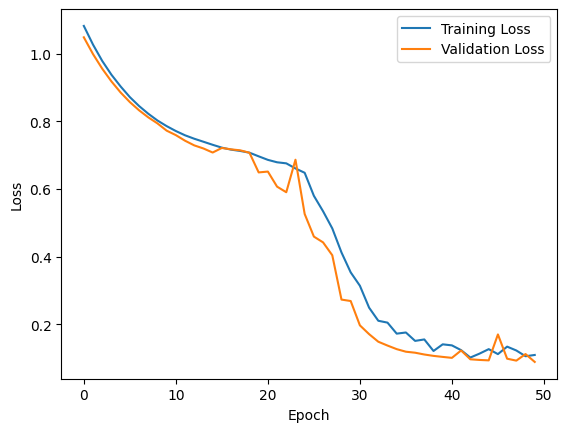

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 0s 3ms/step - loss: 0.0888 - accuracy: 1.0000
Test Accuracy: 100.00%


In [ ]:
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels
y_pred = np.round(y_pred_probs).flatten()
# Convert numerical encoding back to original labels
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred.astype(int))

4/4 [==============================] - 0s 2ms/step


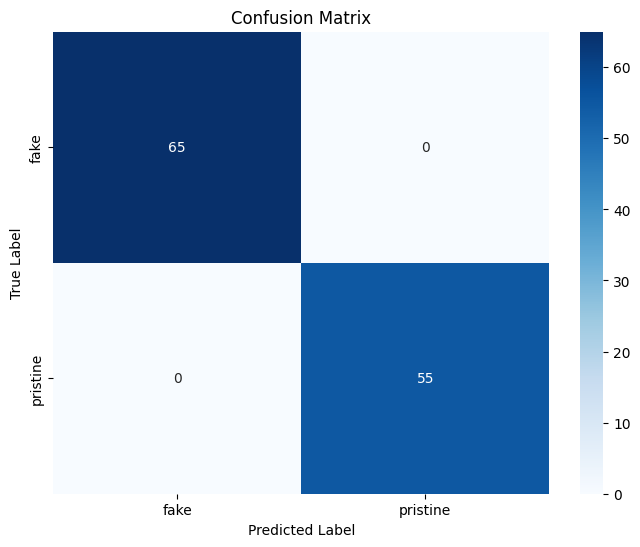

In [ ]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
class_report = classification_report(y_test_labels, y_pred_labels)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        65
    pristine       1.00      1.00      1.00        55

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



### Conclusion:
We can see that the model achieved the maximum F1 score, correctly classifying 65 fake audio files and 55 pristine audio files.